In [460]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
#pd.options.display.max_rows

In [461]:
kp = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KenPom Team Metrics.csv')
#kp.head(10)
kp_conf_rat = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/KP_Conf_Ratings.csv')
kp_conf_rat = kp_conf_rat[['Year_Conf', 'Conf_Abb', 'Conf_Rk', 'Conf_Full', 'Conf_Rating']]
kp_conf_rat.head(10)
kp.head(10)

,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed
0,2019,ABILENE CHRISTIAN,Abilene Christian,66.5681,293,66.0042,254,107.1020,87,103.6250,186,96.7466,43,101.5390,119,2.08626,145,15.0
1,2019,AIR FORCE,Air Force,67.2794,269,66.4070,234,98.7687,274,100.4310,250,105.6820,242,107.2750,238,-6.84432,241,NaN
2,2019,AKRON,Akron,68.4518,207,66.0150,253,99.4248,264,99.7930,257,94.0099,11,93.7022,21,6.09084,107,NaN
3,2019,ALABAMA,Alabama,69.8652,124,68.6333,115,102.4780,185,108.1130,100,102.2220,155,96.6354,50,11.47740,59,NaN
4,2019,ALABAMA A&M,Alabama A&M,67.5600,252,65.4905,282,88.7657,347,86.4818,350,104.8620,219,109.1420,265,-22.66000,344,NaN
5,2019,ALABAMA STATE,Alabama State,68.4214,210,67.0597,198,95.3075,322,94.5978,326,106.1970,250,110.9610,304,-16.36330,329,NaN
6,2019,ALBANY (NY),Albany (NY),66.3119,301,65.7351,268,99.2601,267,98.1540,283,103.2160,176,108.0060,250,-9.85221,277,NaN
7,2019,ALCORN STATE,Alcorn State,67.4020,260,65.6105,277,89.3041,346,88.7838,348,108.2200,288,113.4270,332,-24.64300,349,NaN
8,2019,AMERICAN,American,67.6929,247,66.4126,233,104.5920,141,101.7880,221,100.1360,104,104.9190,186,-3.13075,198,NaN
9,2019,APPALACHIAN STATE,Appalachian State,73.1875,27,71.4297,27,104.6920,138,105.9350,141,110.2310,315,109.5440,274,-3.60901,205,NaN


In [462]:
# All In One Go,

# Prep initial df,
d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
d = pd.merge(d, kp, left_on=['Team', 'year'], right_on=['TeamName', 'Season'], how='left')
d = pd.merge(d, kp, left_on=['Team_n1', 'year'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(d, kp, left_on=['Team_n1', 'year_n1'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year_n1'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = df.replace(to_replace='NO IDEA', value=0)
df = df.replace(to_replace='---', value=0)
df = df.fillna(0)

# Convert to Numeric,
df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 
    'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']] = df[['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'games_n1', 'games_started_n1', 'mp_per_g_n1', 'fg_per_g_n1', 'fga_per_g_n1', 'fg_pct_n1', 'fg2_per_g_n1', 'fg2a_per_g_n1', 'fg2_pct_n1', 'fg3_per_g_n1', 'fg3a_per_g_n1', 'fg3_pct_n1', 'ft_per_g_n1', 'fta_per_g_n1', 'ft_pct_n1', 'orb_per_g_n1', 'drb_per_g_n1', 'trb_per_g_n1', 'ast_per_g_n1', 'stl_per_g_n1', 'blk_per_g_n1', 'tov_per_g_n1', 'pf_per_g_n1', 'pts_per_g_n1', 'sos_n1', 'mp_n1', 'fg_n1', 'fga_n1', 'fg2_n1', 'fg2a_n1', 'fg2_pct.1_n1', 'fg3_n1', 'fg3a_n1', 'ft_n1', 'fta_n1', 'orb_n1', 'drb_n1', 'trb_n1', 'ast_n1', 'stl_n1', 'blk_n1', 'tov_n1', 'pf_n1', 'pts_n1', 'fg_per_min_n1', 'fga_per_min_n1', 'fg2_per_min_n1', 'fg2a_per_min_n1', 'fg3_per_min_n1', 'fg3a_per_min_n1', 'ft_per_min_n1', 'fta_per_min_n1', 'trb_per_min_n1', 'ast_per_min_n1', 'stl_per_min_n1', 'blk_per_min_n1', 'tov_per_min_n1', 'pf_per_min_n1', 'pts_per_min_n1', 'fg_per_poss_n1', 'fga_per_poss_n1', 'fg2_per_poss_n1', 'fg2a_per_poss_n1', 'fg3_per_poss_n1', 'fg3a_per_poss_n1', 'ft_per_poss_n1', 'fta_per_poss_n1', 'trb_per_poss_n1', 'ast_per_poss_n1', 'stl_per_poss_n1', 'blk_per_poss_n1', 'tov_per_poss_n1', 'pf_per_poss_n1', 'pts_per_poss_n1', 'off_rtg_n1', 'def_rtg_n1', 'per_n1', 'ts_pct_n1', 'efg_pct_n1', 'fg3a_per_fga_pct_n1', 'fta_per_fga_pct_n1', 'pprod_n1', 'orb_pct_n1', 'drb_pct_n1', 'trb_pct_n1', 'ast_pct_n1', 'stl_pct_n1', 'blk_pct_n1', 'tov_pct_n1', 'usg_pct_n1', 'ows_n1', 'dws_n1', 'ws_n1', 'ws_per_40_n1', 'obpm_n1', 'dbpm_n1', 'bpm_n1', 'year_n1', 'Ht_n1', 'Wt_n1', 'G_n1', 'S_n1', 'X.Min_n1', 'ORtg_n1', 'X.Poss_n1', 'X.Shots_n1']].apply(pd.to_numeric, errors='ignore')

# Add Contributions,
conditions = [(df['X.Poss_n1']>=28.0), (df['X.Poss_n1']>=24.0), (df['X.Poss_n1']>=20.0), (df['X.Poss_n1']>=16),
            (df['X.Poss_n1']>=12.0), (df['X.Poss_n1']<12)]
                                       #& (df['X.Min_n1']>=10.0))],
#(df['X.Min_n1']<10),,
#values = ['Go-To Guy', 'Major Contributor', 'Significant Contributor', 'Role Players', 'Limited Role', 'Nearly Invisible', 'Bench Warmer'],
values = [0, 1, 2, 3, 4, 5]
df['Contribution_n1'] = np.select(conditions, values)

# Add Year in School KP,
year_cond = [(df['Yr_n1']=='Fr'), (df['Yr_n1']=='So'),
            (df['Yr_n1']=='Jr'), (df['Yr_n1']=='Sr')]
year_val = [1, 2, 3, 4]
df['Class'] = np.select(year_cond, year_val)

# Add Ht. Categories,
ht_cond = [(df['Ht']<=74), (df['Ht']>74) & (df['Ht']<=76), (df['Ht']>76) & (df['Ht']<=78),
   (df['Ht']>78) & (df['Ht']<=80), (df['Ht']>80)]

ht_val = [0, 1, 2, 3, 4]
df['Pos_Ht'] = np.select(ht_cond, ht_val)
#df[‘column’] =( df[‘column’] – df[‘column’].mean() ) / df[‘column’].std(),

    
# Additional Features + Model Prep,
df = df.drop(df[(df['games']<=20) & (df['games_started']/df['games']>0.7)].index)
df = df.drop(df[(df['games_n1']<=20) & (df['games_started_n1']/df['games_n1']>0.7)].index)

df = df.drop(df.loc[((df['games']>39) & (df['year']==2023)) | ((df['games_n1']>39) & (df['year_n1']==2023)) | 
   ((df['games']>40) & (df['year']==2022)) | ((df['games_n1']>40) & (df['year_n1']==2022)) | 
   ((df['games']>33) & (df['year']==2021)) | ((df['games_n1']>33) & (df['year_n1']==2021)) | 
   ((df['games']>35) & (df['year']==2020)) | ((df['games_n1']>35) & (df['year_n1']==2020)) | 
   ((df['games']>40) & (df['year']==2019)) | ((df['games_n1']>40) & (df['year_n1']==2019)) |
   (df['year']==0)]['Player.Name'].index)
idx = df.groupby(['Team', 'year'])['games'].max()
a = pd.DataFrame(idx)
ab = a.reset_index()
ab.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab, left_on=['Team', 'year'], right_on=['Team_max', 'year_max'], how='left')
idx2 = df.groupby(['Team_n1', 'year_n1'])['games_n1'].max()
a2 = pd.DataFrame(idx2)
ab2 = a2.reset_index()
ab2.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab2, left_on=['Team_n1', 'year_n1'], right_on=['Team_max', 'year_max'], how='left')
df.columns
tt = df[['Player.Name', 'Team', 'year', 'games_max_x', 'Team_n1', 'year_n1', 'games_max_y', 'games_n1']]
tt[tt['Player.Name']=='tevin-mack-1']
df = df.drop(df[(df['games']<=0.2*df['games_max_x'])].index)
df = df.drop(df[(df['games_n1']<=0.2*df['games_max_y'])].index)
df = df.drop(df.loc[(df['games_max_x']<24)].index)
df = df.drop(df.loc[(df['games_max_y']<24)].index)

#df = df.drop(df.loc[(df['year']==2020) | (df['year_n1']==2020)].index)
#df = df.drop(df[(df['X.Min_n1']<=10)].index)
#df = df.drop(df[(df['X.Min']<=10)].index)
df['Year_dif'] = df['year_n1']-df['year']
df['Team_AdjEM_dif'] = df['AdjEM_y']-df['AdjEM_x']
df['KP_Rk_Dif'] = df['RankAdjEM_y']-df['RankAdjEM_x']
df['KP_Conf_Dif'] = df['Conf_Rating_y']-df['Conf_Rating_x']
df['Calc A'] = df['X.Min']*df['ws']
df['Calc A2'] = df['X.Min']*df['bpm']
df['Calc A2_n1'] = df['X.Min_n1']*df['bpm_n1']
df['Calc A_n1'] =df['X.Min_n1']*df['ws_n1']
df['Calc B'] = (df['stl_per_poss']+df['blk_per_poss']+df['DR.'])*df['X.Min']
df['Calc B_n1'] = (df['stl_per_poss_n1']+df['blk_per_poss_n1']+df['DR._n1'])*df['X.Min_n1']
df['Calc C']=(df['off_rtg']-df['def_rtg'])*df['X.Min']
df['Calc C_n1']=(df['off_rtg_n1']-df['def_rtg_n1'])*df['X.Min_n1']
df['Calc Overall'] = df['Calc A'] + df['Calc B']
df['Calc Overall_n1'] = df['Calc A_n1'] + df['Calc B_n1']
    
    
# Calc_A_n1_cond = [(df['Calc A_n1']<=340), (df['Calc A_n1']>340) & (df['Calc A_n1']<=664), (df['Calc A_n1']>664) & (df['Calc A_n1']<=1010),,
#            (df['Calc A_n1']>1010) & (df['Calc A_n1']<=1415), (df['Calc A_n1']>1415)],

# Calc_A_n1_val = [0, 1, 2, 3, 4],
# df['Calc_A_Contr'] = np.select(Calc_A_n1_cond, Calc_A_n1_val),
column_to_test = 'Calc A2_n1'
# Calc_overall_n1_cond = [(df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()) & (df[column_to_test]<=(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()), ,
#                         (df[column_to_test]>(df[column_to_test].max()-df[column_to_test].min())/2+df[column_to_test].min()) & (df[column_to_test]<=8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min()),,
#                         (df[column_to_test]>8*(df[column_to_test].max()-df[column_to_test].min())/10+df[column_to_test].min())],

                        # & (df[column_to_test]<=4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min()), ,
                        #(df[column_to_test]>4*(df[column_to_test].max()-df[column_to_test].min())/6+df[column_to_test].min())],
# Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.12)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.12)) & (df[column_to_test]<=df[column_to_test].quantile(0.27)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.27)) & (df[column_to_test]<=df[column_to_test].quantile(0.68)),
#                         (df[column_to_test]>df[column_to_test].quantile(0.68))]
Calc_overall_n1_cond = [(df[column_to_test]<=df[column_to_test].quantile(0.5)),
                        (df[column_to_test]>df[column_to_test].quantile(0.5)) & (df[column_to_test]<=df[column_to_test].quantile(0.88)),
                        (df[column_to_test]>df[column_to_test].quantile(0.88))]
Calc_A_n1_val = [2, 1, 0]
#Calc_A_n1_val = [3, 2, 1, 0]
df['Calc_Overall_n1_Contr'] = np.select(Calc_overall_n1_cond, Calc_A_n1_val)

/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_13383/2260924475.py:4: DtypeWarning: Columns (13,16,38,144,147,169) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv('/Users/caldavis/Documents/GitHub/Capstone-project/Data folder/final_data_by_player_type.csv')
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_13383/2260924475.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Contribution_n1'] = np.select(conditions, values)
/var/folders/cq/16hkxgp926d466c0g9jzx2900000gq/T/ipykernel_13383/2260924475.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [463]:
#df[['Team', 'year', 'games_max']].sort_values('games_max')


In [464]:
from sklearn.preprocessing import StandardScaler
# feature1 = ['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 
#                    'Year_dif',  'Calc A', 'Calc B', 
#                  'DR.',  'Team_AdjEM_dif', 'player_type',
#                  'Class', 'player_type', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg']
feature1 = ['games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg_pct', 'fg2_per_g', 'fg2a_per_g', 'fg2_pct', 'fg3_per_g', 'fg3a_per_g', 'fg3_pct', 'ft_per_g', 'fta_per_g', 'ft_pct', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg2_pct.1', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 
    'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 
    'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots']
# , 'X.Min', 'obpm', 'dbpm
# , 'Calc_Overall_n1_Contr'
y_try = df[['Calc_Overall_n1_Contr']]
#y_try = df[['Contribution_n1']]
df_temp = df
#print(df_temp.columns)
df_temp = df_temp.drop(['Calc_Overall_n1_Contr'], axis=1)
#df_temp = df_temp.drop(['Contribution_n1'], axis=1)
x_try = df_temp.loc[:, feature1].values
#y_try = df.loc[:,['target']].values

x_try = StandardScaler().fit_transform(x_try)

from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, whiten=True)

principalComponents = pca.fit_transform(x_try)

principalDf = pd.DataFrame(data = principalComponents)
#principalDf = pd.concat([principalDf, df_temp['player_type']], axis=1)
principalDf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.098230,-1.605690,-1.165678,-0.727422,-0.583824,-0.548178,0.330767,-0.651684,0.699237,0.255082,0.533793,-0.365816,0.167681,0.409122,-0.475213,-0.530923
1,0.600016,-0.072044,-1.855376,0.534515,-0.496193,-0.293128,0.180025,1.223329,0.760216,-0.292659,0.196959,-0.131558,0.371110,-1.576489,0.292747,0.359749
2,1.847265,0.487259,-0.821912,-0.196307,0.197597,0.138233,0.152600,0.661493,-0.165436,-0.291477,0.076977,1.310117,-0.999575,-0.552065,0.308507,0.709050
3,0.168808,-1.923892,-0.359748,1.658604,-1.296490,0.269392,-0.583653,1.423170,0.410630,-0.895441,-0.348284,0.007466,1.531810,0.435137,-0.218599,-0.051570
4,-0.593654,-1.205780,1.063039,1.457144,-0.867359,0.268393,-0.504408,0.950042,0.971791,-0.987721,-0.839595,0.912188,-0.560838,2.028946,0.276605,0.094340
5,-0.572441,-1.057922,0.135420,1.522800,-0.070495,0.098015,-1.380078,0.533966,0.168782,1.072505,0.032511,-0.401471,-0.566527,1.347936,-0.320751,-0.232593
6,-0.056761,-1.243039,-1.111402,1.391110,-0.197663,0.137679,-0.805772,-0.762393,-0.395917,-0.454340,-0.445145,0.369725,1.138464,0.031900,-0.507776,-1.015840
7,-0.309603,0.876480,-2.604047,-1.093963,0.234156,-0.930142,1.274434,0.912299,-0.816448,0.799890,-1.226196,0.824421,-0.662771,-1.078747,-1.198251,-0.373826
8,-0.554506,1.223729,-1.843320,0.469117,0.709443,-0.130375,-1.411969,0.461181,-0.808758,1.112407,0.548042,-0.103553,0.535159,-0.960187,-0.139404,-0.962067
9,-0.182657,-0.809279,1.015917,0.469289,-0.061133,-0.700657,0.494919,-1.973127,0.690683,0.061988,0.232910,-0.864856,0.307504,-0.355151,-1.455663,-2.227223


In [465]:
# loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PCA10'], index=feature1)
# pd.set_option('display.max_rows', None)
# loadings

In [466]:
df['Calc A2_n1'].quantile(0.83)

253.64039999999991

array([[<Axes: title={'center': 'Calc A2_n1'}>]], dtype=object)

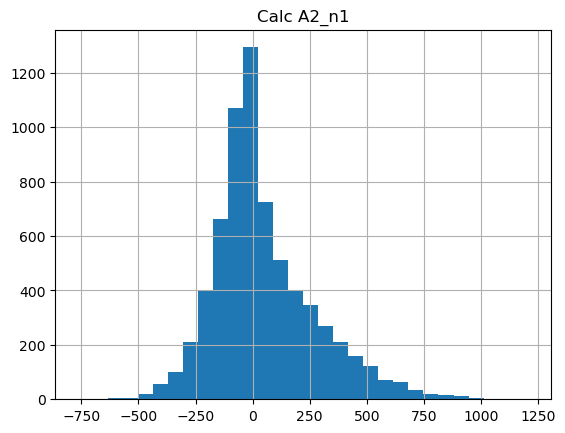

In [467]:
df.hist('Calc A2_n1', bins=30)

In [468]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import neighbors
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier


#df_test1 = principalDf - This one
df_test1 = df[['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 
                   'Year_dif',  'Calc A', 'Calc B', 
                 'DR.',  'Team_AdjEM_dif', 'player_type',
                 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm', 'Contribution_n1', 'Calc_Overall_n1_Contr']]
# 'games', 'games_started', 'Calc A', 'Calc B', 'ast_per_poss', 'pts_per_poss', 'Ht', 'Wt', 'stl_per_poss', 'blk_per_poss', , ,
#df_test1 = df_test1[df_test1['player_type']==0],
# 'Calc Overall', 'Calc_Overall_Contr',
#'player_type', 'KP_Rk_Dif', 'ORtg', 'X.Min',,
#'Team_AdjEM_dif', 'X.Min_n1', 'X.Poss_n1',,
#df_test1 = df_test1[df_test1['player_type']==0],
columns = list(df_test1.columns)
columns.remove('Contribution_n1')

#columns.remove('Calc_Overall_Contr'),
columns.remove('Calc_Overall_n1_Contr')
columns.remove('player_type')
#columns.remove('Calc A2')
#,
keep_col = ['player_type'] #- This one
#keep_col = []
rem_columns = columns
check = True
accuracy_end = 0
while len(rem_columns)>0 and check == True:
    acc_check = 0

    for col in rem_columns:
        X = df_test1[keep_col + [col]]
    # X = df_test1[['player_type', 'X.Poss', 'X.Min', 'X.Min_n1', 'ORtg', ,
    #                       'Year_dif', 'stl_per_poss', 'blk_per_poss', ,
    #                       'DR.', 'KP_Rk_Dif', 'Calc A']],
        #y = df_test1[['Contribution_n1']],
        y = df_test1[['Calc_Overall_n1_Contr']]
        #y = y_try
        #y = df_test1[['Contribution_n1']],
        # Model,
        seed = 7
        test_size = 0.15
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        # Random Forrest
        # model = RandomForestClassifier()
        # model.fit(X_train, y_train)

        # Naive-Bayes
        # model = GaussianNB()
        # model.fit(X_train, y_train)

        # Nearest Neighbors
        # model = neighbors.KNeighborsClassifier()
        # model.fit(X_train, y_train)

        # Support Vector Machine
        # model = svm.SVC(kernel='linear')
        # model.fit(X_train, y_train)
        
        # Gradient Boosting Classifier
        model = GradientBoostingClassifier()
        model.fit(X_train, y_train)
    
        # Find Accuracy,
        accuracy = model.score(X_test, y_test)
        # y_pred = model.predict(X_test),
        # predictions = [round(value) for value in y_pred],
        # accuracy = accuracy_score(y_test, predictions),
        print(keep_col + [col])
        print('Accuracy: ', accuracy * 100)
        if accuracy > acc_check:
            acc_check = accuracy
            col_to_add = col
            check = True
    #print(\Adding: \, col_to_add),
    
    #print(\Rem Columns: \, rem_columns),
    #keep_col = keep_col + [col_to_add],
    if accuracy_end < acc_check:
        print('Adding: ', col_to_add)
        print('Rem Columns: ', rem_columns)
        accuracy_end = acc_check
        print('Accuracy: ', accuracy_end * 100)
        rem_columns.remove(col_to_add)
        keep_col = keep_col + [col_to_add]
    else:
        print('Fails', accuracy_end, acc_check)
        check = False
    print(keep_col)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'bpm']
Accuracy:  67.38491674828599


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2']
Accuracy:  68.46229187071499


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ws']
Accuracy:  58.3741429970617


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'dws']
Accuracy:  57.10088148873653


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ows']
Accuracy:  55.337904015670915


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc Overall']
Accuracy:  53.4769833496572


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'KP_Conf_Dif']
Accuracy:  52.693437806072474


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'X.Poss']
Accuracy:  52.399608227228214


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Year_dif']
Accuracy:  52.10577864838394


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A']
Accuracy:  56.90499510284035


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc B']
Accuracy:  54.06464250734574


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'DR.']
Accuracy:  52.399608227228214


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Team_AdjEM_dif']
Accuracy:  50.44074436826641


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Class']
Accuracy:  52.10577864838394


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Pos_Ht']
Accuracy:  52.10577864838394


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc C']
Accuracy:  58.57002938295789


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'off_rtg']
Accuracy:  52.889324191968655


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'def_rtg']
Accuracy:  55.04407443682664


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'ORtg']
Accuracy:  54.456415279138106


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'X.Min']
Accuracy:  50.930460333006856


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'obpm']
Accuracy:  61.21449559255632


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'dbpm']
Accuracy:  62.19392752203722
Adding:  Calc A2
Rem Columns:  ['bpm', 'Calc A2', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  68.46229187071499
['player_type', 'Calc A2']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'bpm']
Accuracy:  68.46229187071499


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ws']
Accuracy:  68.95200783545543


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'dws']
Accuracy:  69.1478942213516


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ows']
Accuracy:  68.75612144955926


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc Overall']
Accuracy:  69.73555337904016


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'KP_Conf_Dif']
Accuracy:  69.44172380019589


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Poss']
Accuracy:  69.3437806072478


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Year_dif']
Accuracy:  68.65817825661117


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc A']
Accuracy:  67.77668952007836


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc B']
Accuracy:  69.04995102840353


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'DR.']
Accuracy:  69.53966699314398


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Team_AdjEM_dif']
Accuracy:  68.95200783545543


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Class']
Accuracy:  68.75612144955926


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Pos_Ht']
Accuracy:  68.56023506366307


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'Calc C']
Accuracy:  69.3437806072478


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg']
Accuracy:  70.61704211557297


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'def_rtg']
Accuracy:  69.53966699314398


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'ORtg']
Accuracy:  69.2458374142997


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'X.Min']
Accuracy:  68.46229187071499


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'obpm']
Accuracy:  70.02938295788442


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'dbpm']
Accuracy:  68.65817825661117
Adding:  off_rtg
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'off_rtg', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  70.61704211557297
['player_type', 'Calc A2', 'off_rtg']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'bpm']
Accuracy:  70.12732615083252


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'ws']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'dws']
Accuracy:  70.32321253672869


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'ows']
Accuracy:  70.22526934378061


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'KP_Conf_Dif']
Accuracy:  69.93143976493633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'X.Poss']
Accuracy:  69.1478942213516


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Year_dif']
Accuracy:  70.12732615083252


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc A']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc B']
Accuracy:  70.02938295788442


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'DR.']
Accuracy:  69.73555337904016


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Team_AdjEM_dif']
Accuracy:  69.63761018609208


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Class']
Accuracy:  70.22526934378061


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Pos_Ht']
Accuracy:  70.42115572967678


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc C']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'def_rtg']
Accuracy:  69.93143976493633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'ORtg']
Accuracy:  70.12732615083252


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'X.Min']
Accuracy:  70.02938295788442


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'obpm']
Accuracy:  69.93143976493633


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'dbpm']
Accuracy:  70.32321253672869
Adding:  Calc Overall
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  70.81292850146916
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'bpm']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'ws']
Accuracy:  70.32321253672869


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'dws']
Accuracy:  70.42115572967678


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'ows']
Accuracy:  70.32321253672869


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'X.Poss']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Year_dif']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Calc A']
Accuracy:  70.22526934378061


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Calc B']
Accuracy:  70.32321253672869


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'DR.']
Accuracy:  69.63761018609208


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Team_AdjEM_dif']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Class']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Pos_Ht']
Accuracy:  69.83349657198825


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'Calc C']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'def_rtg']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'ORtg']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'X.Min']
Accuracy:  69.63761018609208


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'obpm']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'dbpm']
Accuracy:  70.22526934378061
Adding:  KP_Conf_Dif
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'KP_Conf_Dif', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  71.10675808031341
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'bpm']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'ws']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'dws']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'ows']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'X.Poss']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Year_dif']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Calc A']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Calc B']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'DR.']
Accuracy:  70.02938295788442


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Team_AdjEM_dif']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class']
Accuracy:  71.49853085210577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Pos_Ht']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Calc C']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'def_rtg']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'ORtg']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'X.Min']
Accuracy:  70.32321253672869


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'obpm']
Accuracy:  71.4005876591577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'dbpm']
Accuracy:  71.3026444662096
Adding:  Class
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Class', 'Pos_Ht', 'Calc C', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  71.49853085210577
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'bpm']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'ws']
Accuracy:  71.59647404505387


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'dws']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'ows']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'X.Poss']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Year_dif']
Accuracy:  71.59647404505387


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Calc A']
Accuracy:  70.02938295788442


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Calc B']
Accuracy:  71.4005876591577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'DR.']
Accuracy:  70.91087169441724


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Team_AdjEM_dif']
Accuracy:  71.4005876591577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Pos_Ht']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'Calc C']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'def_rtg']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'ORtg']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'X.Min']
Accuracy:  70.71498530852107


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm']
Accuracy:  71.69441723800196


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'dbpm']
Accuracy:  71.00881488736532
Adding:  obpm
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Pos_Ht', 'Calc C', 'def_rtg', 'ORtg', 'X.Min', 'obpm', 'dbpm']
Accuracy:  71.69441723800196
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'bpm']
Accuracy:  71.79236043095005


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws']
Accuracy:  71.98824681684623


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'dws']
Accuracy:  71.4005876591577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ows']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'X.Poss']
Accuracy:  70.91087169441724


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Year_dif']
Accuracy:  71.49853085210577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Calc A']
Accuracy:  71.10675808031341


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Calc B']
Accuracy:  71.49853085210577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'DR.']
Accuracy:  70.12732615083252


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Team_AdjEM_dif']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Pos_Ht']
Accuracy:  70.91087169441724


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'Calc C']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'def_rtg']
Accuracy:  70.91087169441724


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ORtg']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'X.Min']
Accuracy:  70.51909892262488


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'dbpm']
Accuracy:  71.3026444662096
Adding:  ws
Rem Columns:  ['bpm', 'ws', 'dws', 'ows', 'X.Poss', 'Year_dif', 'Calc A', 'Calc B', 'DR.', 'Team_AdjEM_dif', 'Pos_Ht', 'Calc C', 'def_rtg', 'ORtg', 'X.Min', 'dbpm']
Accuracy:  71.98824681684623
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws']


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'bpm']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'dws']
Accuracy:  71.4005876591577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'ows']
Accuracy:  70.81292850146916


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'X.Poss']
Accuracy:  71.49853085210577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Year_dif']
Accuracy:  70.91087169441724


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Calc A']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Calc B']
Accuracy:  71.00881488736532


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'DR.']
Accuracy:  70.12732615083252


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Team_AdjEM_dif']
Accuracy:  71.49853085210577


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Pos_Ht']
Accuracy:  70.61704211557297


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'Calc C']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'def_rtg']
Accuracy:  70.61704211557297


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'ORtg']
Accuracy:  71.2047012732615


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'X.Min']
Accuracy:  71.3026444662096


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws', 'dbpm']
Accuracy:  71.4005876591577
Fails 0.7198824681684622 0.7149853085210578
['player_type', 'Calc A2', 'off_rtg', 'Calc Overall', 'KP_Conf_Dif', 'Class', 'obpm', 'ws']


In [469]:
output = pd.DataFrame(y_test['Calc_Overall_n1_Contr'])
output = output.rename(columns={'Calc_Overall_n1_Contr': 'Actual'})

output['Predictions'] = model.predict(X_test)
output3 = output.groupby('Predictions').count()
output['Better'] = np.where(output['Predictions']==output['Actual'], 1, 0)
output2 = output.groupby(['Actual', 'Predictions']).count()

output2

Better
Actual Predictions        
0      0                52
       1                58
       2                 5
1      0                26
       1               222
       2               126
2      0                 1
       1                76
       2               455